In [1]:
#Welcome back

In [2]:
#in the last session, we saw how to implement MLP for char level prediction based on previous characters
#before we for complex and larger neural networks liks RNN, GRU etc..
#but we will revisit MLP again to understand more about Activations in neural net during training,
#specially gradients back propagating, how they behave and look like...

#this helps to understand the history of evolution of complex networks
#because RNN while they are very expressive which they are universal approximator  and in priciple can implement all the
#algorithms, but they are not easily optimizable with 1st order gradient techniques that we have avilable to us and use 
#all the time.

#key to understand why RNN is not easily optimizable we need to understand the gradients and how they behave during 
#training. 

#so let's get started...

In [3]:
#we have take some of the codes from previous session and cleaned up a little...

In [1]:
from IPython.display import Image
from IPython.display import display

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#reading text file and split data and store as list
words = open('names.txt').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
#building vocab of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
#buid the dataset
block_size = 3 #context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words) #random shuffling
n1 = int(0.8*len(words)) 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% words in to train dataset
Xdev, Ydev = build_dataset(words[n1:n2]) #10% into validation
Xte, Yte = build_dataset(words[n2:]) #rest 10% for test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
#MLP Revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [9]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9332
  20000/ 200000: 2.5127
  30000/ 200000: 2.8069
  40000/ 200000: 2.0142
  50000/ 200000: 2.4315
  60000/ 200000: 2.4147
  70000/ 200000: 2.0744
  80000/ 200000: 2.4390
  90000/ 200000: 2.3830
 100000/ 200000: 2.0478
 110000/ 200000: 2.3100
 120000/ 200000: 1.9483
 130000/ 200000: 2.4335
 140000/ 200000: 2.2633
 150000/ 200000: 2.1373
 160000/ 200000: 2.0635
 170000/ 200000: 1.8053
 180000/ 200000: 2.0544
 190000/ 200000: 1.8314


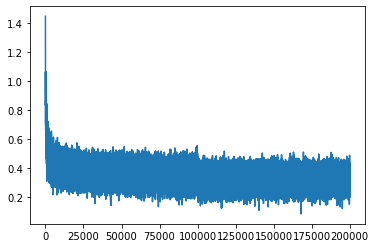

In [10]:
plt.plot(lossi)

In [11]:
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1240813732147217
val 2.1658542156219482


In [12]:
#Generating sequence of characters....

In [13]:
#Ssample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])] #1, block_size, n_embd
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the contect window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special char '.', then break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word
    

mona.
mayah.
seel.
nihahla.
ren.
ruchadrael.
adered.
elin.
shy.
jenne.
elionna.
arleit.
kollyan.
noshubergiag.
jest.
jairenelionnterianu.
zen.
dariyah.
fael.
yuma.


In [14]:
#output looks much better than perceptron model!!!

In [15]:
#first things to scrutinize is "Initialization" of weights
#why ? Very improperly configured !!
#notice in 1st iteration loss is very high around 27, whereas in next iteration comes to ~2 because of improper config
#in training of neural net, better to have rough idea for what loss to expect at initialization
#how do we calculate? it depends on loss function and problem setup...

In [16]:
#in our example....
#basically at input, we can expect any 1 of 27 characters in training example
#At initialization, prob dist for all char should be uniform dist, assigning equal prob to all chars
# i.e.

1 / 27

0.037037037037037035

In [17]:
-torch.tensor(1/27).log() #negative log probability

tensor(3.2958)

In [18]:
#therfore roughly we expect loss aroung 3 at initialization, much much lower than 27
#currently at initialization, random no's assigned, shooting up loss

In [19]:
#small 4 - dim example of the issue
#Lets say we have only 4 characters, and we have logits of these characters very very close to 0
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0) #taking probabilities of logits
loss = -probs[2].log() #displaying loss function for 3rd tensor
probs, loss #notice the loss is high
#

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [20]:
#small 4 - dim example of the issue
#Lets say we have only 4 characters, and we have logits of these characters very very close to 0
logits = torch.tensor([0.0, 0.0, 5.0, 0.0]) #notice if we change logits for 3rd tensor very high, then loss is reduced
probs = torch.softmax(logits, dim=0) #taking probabilities of logits
loss = -probs[2].log() #displaying loss function for 3rd tensor
probs, loss #notice the loss is low for 3rd tensor

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [21]:
#so we want the logits to be roughly 0 or very close to 0 or all values roughly equal 
#for effective loss value, when initialized 

In [22]:
#lets analyze the function for 1st iteration

In [26]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [27]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break #break after 1st iteration

      0/ 200000: 27.8817


In [28]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [29]:
#notice the huge randomness in logits, causing high loss

In [30]:
#we should make these logits much much closer to 0 or roughtly all logits roughly equal....
#logits are h @  W2 + b2
#b2 is initialized with random values
#since we need logits to near zero, lets make b2 as 0
#similiarly, we will make W2 much small by factor of 0.1, snce we want logits to be very very small values

In [34]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221


In [36]:
#notice, the initial loss is reduces to very small value, near to our expected loss function

In [37]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

In [38]:
#lets run for entire batch

In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2813
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1601


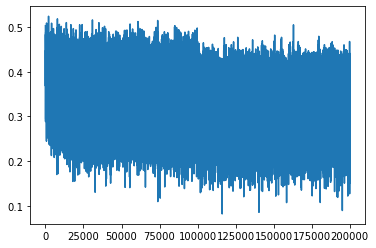

In [40]:
plt.plot(lossi)

In [41]:
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.069577217102051
val 2.131200075149536


In [42]:
#notice now the train & val loss is much improved than previous one

In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 2.3869


In [50]:
#Next, fixing the saturated tanh

In [44]:
#there is a still deeper neural network problem, lets analyze

In [45]:
h

tensor([[ 0.9609,  0.6587,  0.9906,  ..., -0.9999, -1.0000, -0.9505],
        [-0.9369, -1.0000, -1.0000,  ...,  0.9998, -0.9998, -1.0000],
        [-0.9889, -0.9948,  0.6714,  ..., -1.0000,  1.0000,  1.0000],
        ...,
        [-1.0000,  0.8726, -0.9797,  ..., -0.8593,  0.9812,  1.0000],
        [-1.0000,  0.5758, -1.0000,  ..., -0.9890, -0.8869,  0.9810],
        [-1.0000,  0.8907,  0.3096,  ...,  0.8796,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [46]:
#notice many values are 1 or -1 . why ??
#h is a wrapper on tanh fucntion. it squases values between 1 & -1

h.shape

torch.Size([32, 200])

(array([2186.,  124.,  116.,   86.,   46.,   57.,   52.,   28.,   18.,
          23.,   47.,   41.,   51.,   18.,   34.,   23.,   23.,   32.,
           7.,   15.,   27.,   18.,   17.,   17.,   22.,   14.,   25.,
           9.,   13.,   27.,   18.,   27.,   22.,   28.,   17.,   32.,
          19.,   41.,   20.,   22.,   24.,   27.,   40.,   48.,   50.,
          72.,   60.,   83.,  120., 2414.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

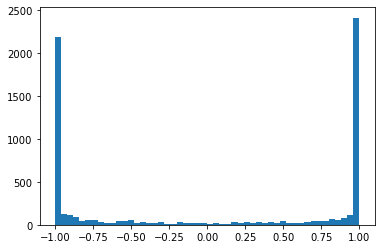

In [47]:
plt.hist(h.view(-1).tolist(), 50)

In [48]:
#notice how tanh histogram is going to extreme sides of -1 & -1, why ?
#because, lets analyze preactivation func

(array([  5.,   0.,   5.,  10.,   5.,   8.,  13.,  14.,  18.,  24.,  41.,
         71.,  77.,  88., 138., 152., 215., 233., 246., 266., 312., 357.,
        446., 509., 471., 340., 309., 263., 303., 305., 201., 226., 145.,
        153.,  94.,  89.,  68.,  51.,  39.,  28.,  16.,  22.,  11.,   3.,
          4.,   0.,   1.,   0.,   2.,   3.]),
 array([-22.65315628, -21.69806881, -20.74298134, -19.78789387,
        -18.8328064 , -17.87771893, -16.92263145, -15.96754398,
        -15.01245651, -14.05736904, -13.10228157, -12.1471941 ,
        -11.19210663, -10.23701916,  -9.28193169,  -8.32684422,
         -7.37175674,  -6.41666927,  -5.4615818 ,  -4.50649433,
         -3.55140686,  -2.59631939,  -1.64123192,  -0.68614445,
          0.26894302,   1.22403049,   2.17911797,   3.13420544,
          4.08929291,   5.04438038,   5.99946785,   6.95455532,
          7.90964279,   8.86473026,   9.81981773,  10.7749052 ,
         11.72999268,  12.68508015,  13.64016762,  14.59525509,
         15.550342

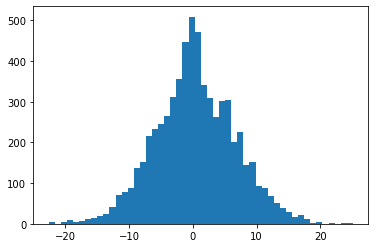

In [49]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [51]:
#notice the distribution of preact func is very very broad, leading tanh to land in surface areas
#hpreact has 200 hidden neurons and each neuron is applied with tanh function

In [52]:
#what happend when we apply tanh in backward pass ?
#let's revist our micrograd notebook on implementation of tanh

'''
def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

'''

"\ndef tanh(self):\n        x = self.data\n        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)\n        out = Value(t, (self, ), 'tanh')\n        def _backward():\n            self.grad = (1 - t**2) * out.grad\n        out._backward = _backward\n        return out\n\n"

In [53]:
#in backward pass, how do we back propagate tanh ??
#we multiply the local gradient i.e. out.grad with  1 - t^2
#What happens when the output of tanh is very close to -1 or +1
# if we plugin these values in (1-t^2)*out.grad, turns out that gradient is 0 i.e. we are killing the gradient
#inititutively this makes sense, because tanh function -1 and +1 is smoother surface and not derivative
#but when t = 0, (1-t^2)*out.grad = 1*out.grad, now out.grad will pass through to next neurons

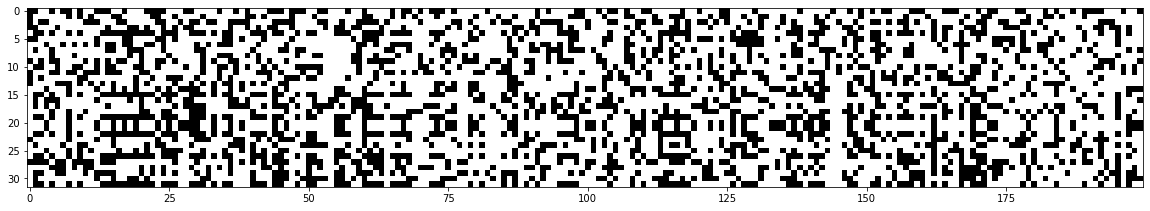

In [54]:
#let us analyze how frequent the values of "h" i.e. output of tanh falls in flat reg#ion
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest') #boolean tensor

In [55]:
#notice lot of white regions, indicating lot of tanha neurons are very active & landing in flating region
#for all these neurons, backprop will be destroyed i.e dead !!!
#there can be chances due to initialization of weights & biases will make entire neurons to in flat region 
#making neurons never learn i.e. dead neuron

In [56]:
#therefor many activation funtions were introduced
#ReLU, LeakyReLU, MaxOut, ELU...

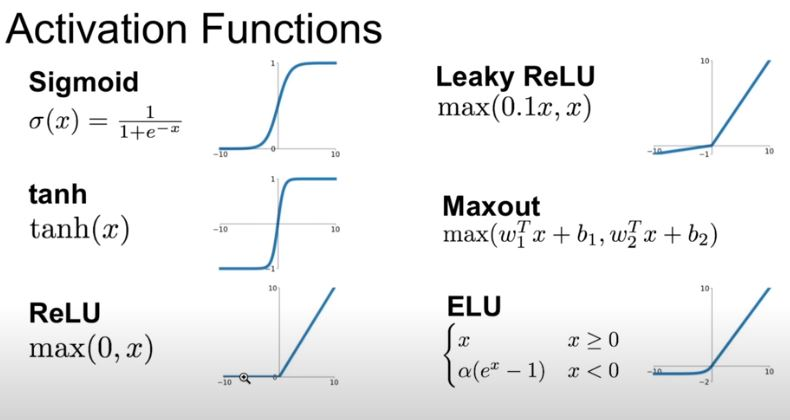

In [57]:
a = Image(r'C:\Users\welcome\Desktop\AndrejKarpathy\activation.JPG')
display(a)

In [58]:
#Revisiting weights & bias intialization
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1 # similarly weights also factored
b1 = torch.randn(n_hidden, generator=g) * 0.01 #making b1 bias little smaller
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [59]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3069


(array([  6.,  17.,  20.,  30.,  49.,  61.,  72.,  89.,  87.,  99., 135.,
        121., 153., 134., 138., 140., 174., 163., 179., 184., 138., 196.,
        183., 226., 165., 212., 191., 175., 201., 211., 189., 186., 166.,
        178., 183., 156., 194., 155., 171., 140., 139., 122., 102.,  96.,
         81.,  72.,  41.,  39.,  23.,  18.]),
 array([-0.95476669, -0.91695139, -0.87913609, -0.84132079, -0.80350549,
        -0.76569018, -0.72787488, -0.69005958, -0.65224428, -0.61442898,
        -0.57661368, -0.53879838, -0.50098307, -0.46316777, -0.42535247,
        -0.38753717, -0.34972187, -0.31190657, -0.27409127, -0.23627596,
        -0.19846066, -0.16064536, -0.12283006, -0.08501476, -0.04719946,
        -0.00938416,  0.02843115,  0.06624645,  0.10406175,  0.14187705,
         0.17969235,  0.21750765,  0.25532295,  0.29313826,  0.33095356,
         0.36876886,  0.40658416,  0.44439946,  0.48221476,  0.52003006,
         0.55784537,  0.59566067,  0.63347597,  0.67129127,  0.70910657,
 

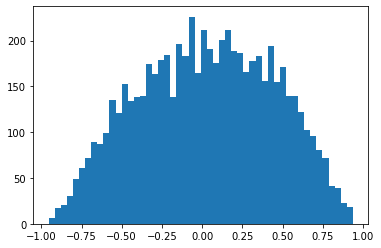

In [60]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  10.,   7.,  12.,  12.,  24.,
         39.,  40.,  76.,  66.,  98., 127., 171., 191., 207., 227., 275.,
        310., 288., 360., 368., 384., 352., 363., 338., 304., 281., 287.,
        229., 207., 166., 137., 101.,  90.,  74.,  46.,  28.,  28.,  21.,
         11.,   8.,  11.,   5.,   2.,   7.]),
 array([-1.88309634, -1.81133971, -1.73958308, -1.66782645, -1.59606983,
        -1.5243132 , -1.45255657, -1.38079994, -1.30904332, -1.23728669,
        -1.16553006, -1.09377343, -1.02201681, -0.95026018, -0.87850355,
        -0.80674692, -0.7349903 , -0.66323367, -0.59147704, -0.51972041,
        -0.44796379, -0.37620716, -0.30445053, -0.2326939 , -0.16093728,
        -0.08918065, -0.01742402,  0.05433261,  0.12608923,  0.19784586,
         0.26960249,  0.34135912,  0.41311574,  0.48487237,  0.556629  ,
         0.62838563,  0.70014225,  0.77189888,  0.84365551,  0.91541214,
         0.98716877,  1.05892539,  1.13068202,  1.20243865,  1.27419528,
 

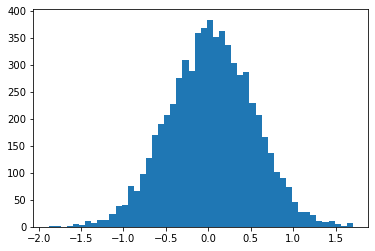

In [61]:
plt.hist(hpreact.view(-1).tolist(), 50)

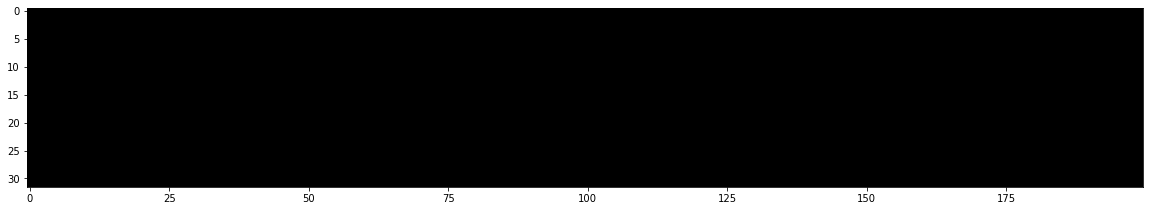

In [62]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest')

In [63]:
#now notice we have much much less white in tanh  output , almost no whites

In [64]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # changing to 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01 #making b1 bias little smaller
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [65]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [66]:
#Rechecking the train & validation loss.....
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


In [67]:
#summary of learinng so far...

#original
#train 2.12
#val 2.16

#fix softmax confidently wrong:
#train 2.07
#val 2.13

#fix tanh layer too saturated at init:
#train 2.03
#val 2.10

In [68]:
#till now we manually tweaked weights & biases and optimized due to network is very shallow
#but obviously when the DNN is very big, we wont be doing manually

In [69]:
#Kaiming Initialization

tensor(-0.0087) tensor(1.0040)
tensor(-0.0010) tensor(3.2308)


(array([2.76267979e-05, 6.90669949e-06, 1.38133990e-05, 7.59736943e-05,
        7.59736943e-05, 1.65760788e-04, 2.48641181e-04, 3.45334974e-04,
        5.87069456e-04, 1.07053842e-03, 1.62307438e-03, 2.38281132e-03,
        3.60529713e-03, 5.98810845e-03, 9.77297977e-03, 1.38962794e-02,
        2.03333233e-02, 2.98645686e-02, 4.18131587e-02, 5.79886489e-02,
        7.67196179e-02, 9.44836490e-02, 1.12890003e-01, 1.29459175e-01,
        1.34273145e-01, 1.30398486e-01, 1.18401549e-01, 1.01404162e-01,
        8.18305755e-02, 6.33965946e-02, 4.72072910e-02, 3.35803729e-02,
        2.35518452e-02, 1.55055403e-02, 1.03047956e-02, 7.12080717e-03,
        4.17164649e-03, 2.51403861e-03, 1.76811507e-03, 8.42617337e-04,
        5.87069456e-04, 4.28215368e-04, 2.55547881e-04, 1.65760788e-04,
        5.52535959e-05, 5.52535959e-05, 4.83468964e-05, 6.90669949e-06,
        6.90669949e-06, 2.07200985e-05]),
 array([-17.84503937, -17.12110458, -16.3971698 , -15.67323502,
        -14.94930023, -14.2253

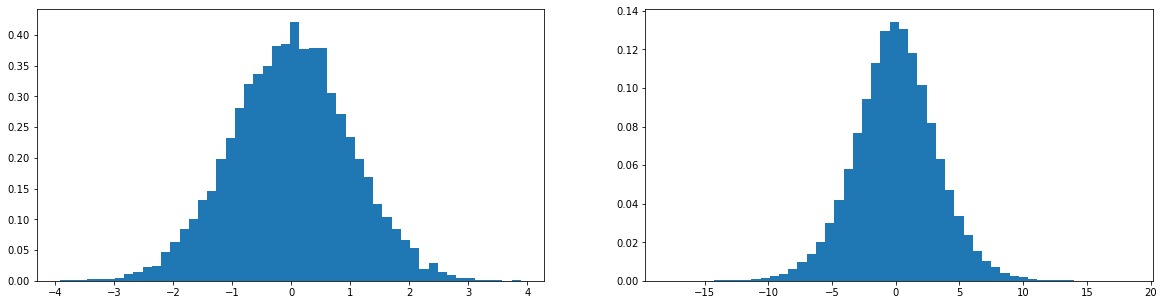

In [70]:
x = torch.randn(1000, 10)#initialized using uniform guassians
w = torch.randn(10, 200) #also from uniform guassian
y = x @ w #lets not add bias and other non linear activation function, to keep it simple
#try to check what is the mean and std dev
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [62]:
#histogram of Y is not a standard guassian as like x
#x has std dev of 1 whereas of Y has std dev of 3
# when we multiply 2 guassian dist, output is not same distribution, even if we scale by a factor

tensor(-0.0034) tensor(0.9886)
tensor(2.1200e-05) tensor(0.9980)


(array([1.91443286e-05, 0.00000000e+00, 0.00000000e+00, 1.91443286e-05,
        3.82886572e-05, 9.57216431e-05, 5.74329858e-05, 1.14865972e-04,
        2.10587615e-04, 6.12618516e-04, 1.16780405e-03, 1.60812360e-03,
        3.19710288e-03, 5.59014395e-03, 9.78275192e-03, 1.60620917e-02,
        2.64191735e-02, 4.64058526e-02, 7.28058817e-02, 1.12070900e-01,
        1.64239195e-01, 2.29349057e-01, 2.99455588e-01, 3.65752398e-01,
        4.16733745e-01, 4.28430930e-01, 4.03964478e-01, 3.48292770e-01,
        2.74510528e-01, 2.05935543e-01, 1.46875289e-01, 9.40752308e-02,
        6.08598207e-02, 3.82695129e-02, 2.31454933e-02, 1.31138651e-02,
        8.65323653e-03, 4.93923678e-03, 2.83336063e-03, 1.37839166e-03,
        7.84917473e-04, 5.36041201e-04, 1.91443286e-04, 1.14865972e-04,
        7.65773144e-05, 3.82886572e-05, 0.00000000e+00, 0.00000000e+00,
        1.91443286e-05, 1.91443286e-05]),
 array([-6.61533833, -6.35416437, -6.09299042, -5.83181646, -5.57064251,
        -5.30946856, 

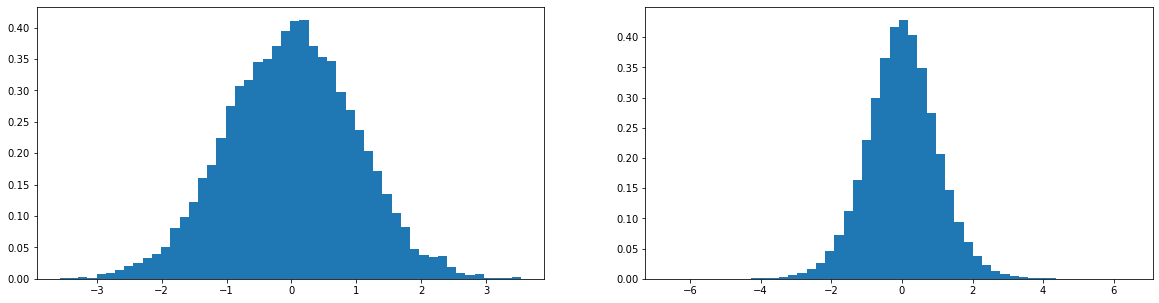

In [71]:
#in order to maintain the same distribution, divide by the square root of fan-in i.e. no of input columns to that layer
x = torch.randn(1000, 10)#initialized using uniform guassians
w = torch.randn(10, 200) / (10 ** 0.5) #divide by square root of no of input neurons
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [72]:
#notice, now the output distribution aligned at mean 0

In [73]:
#no of papers research looked exclusively how to initalize weights
#https://arxiv.org/abs/1502.01852 
#this paper by Kaiming He at al 
#provided a best approach to initialize the weights
#initialize the weights by zero mean guassian whose std dev is square root of 2/no of input neurons to that layer i.e. fanin

In [74]:
#this paper also tells that if we properly initalize weights in forward pass, then
#back prop also approximately initialized
#this type of kaiming initialization is also implemented in pytorch

tensor(0.0057) tensor(1.0140)
tensor(0.0061) tensor(7.2747)


(array([2.91875774e-06, 5.83751548e-06, 5.83751548e-06, 2.91875774e-06,
        1.45937887e-05, 2.91875774e-05, 4.67001238e-05, 1.05075279e-04,
        1.92638011e-04, 3.18144594e-04, 5.07863847e-04, 8.66871049e-04,
        1.41851626e-03, 2.08399303e-03, 3.46748419e-03, 5.27127648e-03,
        8.41477856e-03, 1.21624635e-02, 1.82451546e-02, 2.50954790e-02,
        3.33468072e-02, 4.25204627e-02, 5.02347395e-02, 5.67464880e-02,
        5.90435503e-02, 5.70325262e-02, 5.09644289e-02, 4.26226193e-02,
        3.41377905e-02, 2.49261911e-02, 1.84202801e-02, 1.25389832e-02,
        8.50234129e-03, 5.26252020e-03, 3.53461562e-03, 2.24452470e-03,
        1.33095353e-03, 8.81464837e-04, 4.96188816e-04, 2.62688197e-04,
        1.86800495e-04, 9.04814899e-05, 7.88064590e-05, 4.08626084e-05,
        1.75125464e-05, 1.45937887e-05, 5.83751548e-06, 5.83751548e-06,
        0.00000000e+00, 2.91875774e-06]),
 array([-41.99023056, -40.277173  , -38.56411545, -36.85105789,
        -35.13800034, -33.4249

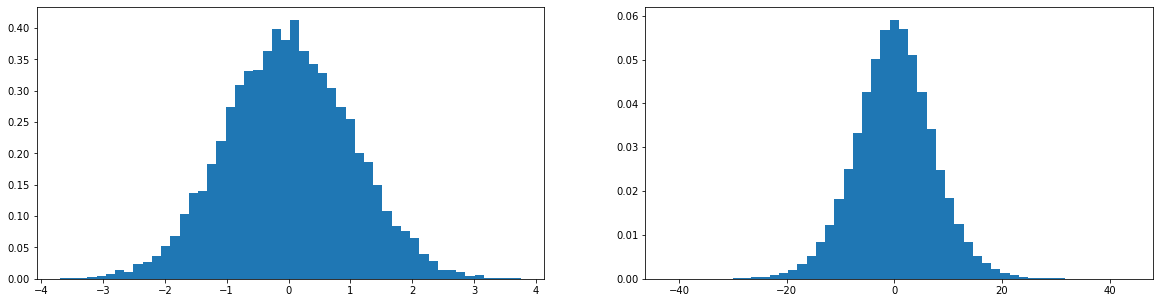

In [75]:
#in order to maintain the same distribution, divide by the square root of fan in i.e. no of input columns to that layer
x = torch.randn(1000, 10)#initialized using uniform guassians
w = torch.randn(10, 200) / (2/10) ** 0.5 #divide by square root of no of input neurons
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [68]:
#in general normalize by square roort of fan in will work for most of the cases
#therefore

In [76]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01 #making b1 bias little smaller
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [77]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


In [78]:
#Rechecking the train & validation loss.....
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.106989622116089


In [79]:
#loss remains same
#Now we have more advanced techiniques of initializations...

In [80]:
#Batch Normalization - made deep neural network train quire reliably
#https://arxiv.org/abs/1502.03167

In [81]:
#basically we have hidden states & we dont want these pre-activation states to be too small or too large
#we want these tanh outputs to be roughtly guassian
#insight from this batch normalization paper is - "take the hidden states and just normalize them to be guassian"

In [82]:
#standardizing states so that their unit caution is perfectly differentiable
#lets see how this works...

In [83]:
hpreact.shape

torch.Size([32, 200])

In [84]:
hpreact.mean(0, keepdim=True).shape #calculate mean at 0th dimension 

torch.Size([1, 200])

In [85]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [86]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01 #making b1 bias little smaller
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [87]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    #this will make every single neuron now & its firing rate will be unit guassian of this batch
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


In [88]:
#we might not achieve good results, why ??
#reason is - we want these states to be roughly guassian but only at initialization !!!!!
#but we dont want to be forced to be guassian always
#we want to allow neural net to move this values around to potentially make it more diffuse,
#more sharp etc...
#we want back prop should tell us how this distribution should move around

In [89]:
#hence we introduce additional component as mentioned in the paper, described as scale & shift
#taking the normalized inputs and additionally scalling them by some gain  & offsetting by some bias

In [90]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01 #making b1 bias little smaller
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

bngain = torch.ones(1, n_hidden) #batch normalization gain
bnbias = torch.zeros(1, n_hidden) #batch normalization bias

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [91]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    #implemented addtional scale & shift factor
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [92]:
#at initialization - bngain = 1 & bnbia = 0 , hence all weights are exactly unit guassian weights
#during backpropagate - these will learned accordingly

In [94]:
#Rechecking the train & validation loss.....
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


In [95]:
#summary of learinng so far...

#original
#train 2.12
#val 2.16

#fix softmax confidently wrong:
#train 2.07
#val 2.13

#fix tanh layer too saturated at init:
#train 2.03
#val 2.10

#with Batch Norm layer
#train: 2.06
#val: 2.10

In [98]:
#loss has not significant improvement, but definitely will impact when we have multiple hidden layers
#when the neural net have multiple hidden layers, difficult to tune the scales of weight matrices such that all the
#activations throughout the neural nets are roughly guassian.
#so, with batch norm it is much easier to control the scale of activations at every point in neural net
#we will be adding this batch norm layers through out the neural network
#it significantly stablized the training

In [99]:
#Stability offered by Batch Norm actually comes at a terrible cost!!!
#we have sigle example feeding into neural net, and we calculate its activations and logits, which is deterministic.
#because of efficiency of training, we suddenly started to use batches, where these batches are processed independently.
#in batch norm, we are coupling these examples mathematically both in forward and backward pass of neural net.
#Now, the hidden state activations hpact & logits, for any 1 input example are not just a function of that example, but
#they are alos a function of all other examples of tha batch and these batch examples are sampled randomly

#h is goint to change suddenly based on the examples present in the batch getting added into batch norm and goint to jitter
#similarly jitter for logits.

In [100]:
#this may feel like issue, behaves like data agumentation...
#but batch norm act as "regularizer" & stablized training

In [101]:
#introducing batch norm has other impact ???
#Basically once we trained a neuran network, we like to deploy it.
#we will like to feed single individual input and get a prediction out of it
#But how do we do that when our neural net in a forward pass estimates the statistics of mean & std dev of batch?
#as the model expects input as batch...

In [102]:
#how do we feed single input and get sensible results out
#Same paper provides a solution
#basically we have a step after training that calculates & sets the batch norm mean & std dev a single time 
#over the training set

In [103]:
#calculate the batch norm at the end of training

with torch.no_grad(): #no_grad ensure for none of below operations no backward prop is called
    #paass the training set through
    emb = C[Xtr] #take training set
    embcat = emb.view(emb.shape[0], -1) #embedded it
    hpreact = embcat @ W1 + b1 #get preactivation weights
    #measure the mean & std dev over the entire training set
    bnmean = hpreact.mean(0, keepdim=True) #caluclate mean
    bnstd = hpreact.std(0, keepdim=True) #and std dev

In [104]:
#Rechecking the train & validation loss.....
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias #instead of calculating dynamically, use the bnmean & bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


In [105]:
#note the loss is same 
#but benifit we gain is now we can pass a single example & get its predictions

In [106]:
#but no one would like to calculate single batch mean & batch std after trainng
#we need to embed these while training

In [107]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) #for reproducability
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01 #making b1 bias little smaller
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  #making W2 smaller by a factor(0.1, 0.01 etc...)
b2 = torch.randn(vocab_size, generator=g) * 0 #making b2 as zero's

bngain = torch.ones(1, n_hidden) #batch normalization gain
bnbias = torch.zeros(1, n_hidden) #batch normalization bias

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) #no of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [108]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibactch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #bacth X, Y
    
    #forward pass
    emb = C[Xb] #embed the batch characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    # Linear Layer
    hpreact = embcat @ W1 + b1 # hidden layer preactivation - b1 bias not needed, instead batch norm bias will take care
    #Batch Layer
    bnmeani = hpreact.mean(0, keepdim=True) #at ith iteration
    bnstdi = hpreact.std(0, keepdim=True) #at ith iteration
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001* bnstdi
        
    #implemented addtional scale & shift factor
    #Non Linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print evecy once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [109]:
@torch.no_grad() #this decorator disables gradient tracking
#decorator makes sure any updates in tensor grad in below function is not upgrades i.e. making false
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #N, block-size, n_embd
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, Vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [110]:
#no much impact to loss with inbuild batch norm mean & std

In [111]:
#this way we eliminated calculating bnmean & bnstd as seperate entity
#instead now we have found inside the training function

In [112]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6116,
          1.1173,  0.2427,  2.0500,  0.5832,  0.8527,  1.7680, -0.3625, -0.8356,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8260,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4523,  1.1754,  0.5613,  0.6051,
          1.5859,  1.2261, -1.0112,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0389,  0.6608,  0.0692, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8411, -1.2248, -1.0129,  0.2230,
          0.2112, -0.3226,  

In [113]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6241, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0699, -0.0781,  0.3370, -0.5768,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8118,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2400,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0221,  0.2201,
          0.1928, -0.3261,  

In [114]:
#note both are very similar. Similarly bnstd & bnstd_running will be similar

In [115]:
#2 more things to mention
# need to add a small epsilon value in hpreact formula to avoid % by 0 error
#bias at b1 is not needed. since we subtract that in hpreact using bnmeani & bnbias. 
#therefore when using batch norm layers,then if you have any weight layers before , 
#then no need to use bias in that layer....

In [116]:
#Summary of Batch Norm:
# 1. We use batch norm to control the statistics of activations in the neural net
# 2. Normally placed it after layers that have multiplication like linear layer or convolution layer
# 3. Batch Norm internally has parameters - Gain & Bias - trained using Back Prop
# 4. It also has 2 buffers - Mean & Std Dev (Running Mean & Running Std Dev) - not trained using back prop
# 5. It calculates the mean & std dev of activations that are fed into batch norm layer, over that batch
# 6. then it center that batch to be a unit guassian and then its offsetting & scaling it by the learned bias & gain
# 7. on top of that, it tracks the mean & std dev of the inputs and maintain the running mean & running std dev
# 8. this running batch mean & std dev is used at inference time, for individual input estimates
# 9. Fairly complicated, but highly useful layer though we have other forms like layer norm, instance norm etc...

In [117]:
#Till now we saw the importance of activations & gradients and their statistics in neural net where it become 
#increasingly importance when network become huge, large & deep

In [118]:
#We looked at the distribution at output layer & because of activations functions too large or too small leads to
#misinterpretatios of output leading to high loss. we fixed this using better intialization & normalization

### Pytorch functions implementation

In [127]:
#torch has lot of layer functions, one of its Linear Layer
#it takes no of input & output & bias
class Linear: #similar to pytorch nn.linear 
    
    def __init__(self, fan_in, fan_out, bias=True): #fan in : no of inputs, fan out: no of outputs
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None #initialize bias to zeros if needed
    
    def __call__(self, x): #when call this module
        self.out = x @ self.weight #calculates matrix multiplication of weights * inputs i.e w @ x
        if self.bias is not None: #adding bias  x @ w + b
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) #returns tensors containing that layer param

class BatchNorm1d: #similar to pytorm nn.batchnorm1d
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True #differentiates if currently nn is in training, if so calculate running batch mean & std dev
        #parameters (trained with back prop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.ones(dim) #not part of back prop, used only for testing
        self.running_var = torch.ones(dim) #not part of back prop, used only for testing
    
    def __call__(self, x):
        #calculate forward pass
        if self.training: #if in training use batch mean & batch var
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch variance
        else: #for inference using running mean & running var
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #udpate the buffers
        if self.training:
            with torch.no_grad(): #trained only of forward pass - using no_grad context manager
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh: #similar to torch.tanh function
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return [] #no parameters in tanh function to be returned

In [128]:
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 100 #no of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647) #for reproducability

In [129]:
C = torch.randn((vocab_size, n_embd), generator=g)

In [130]:
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]
#now it is easy to stack linear layers by calling class function

In [131]:
with torch.no_grad():
    #last layer: make output softmax function little less confident
    layers[-1].weight *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #modify this gain and see how the visualization impacts

In [132]:
parameters = [C] + [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
print(sum(p.nelement() for p in parameters)) #no of parameter in total
for p in parameters:
    p.requires_grad = True

46497


In [134]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break #AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2944


layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.03%
layer 3 (      Tanh): mean +0.00, std 0.68, saturated: 8.38%
layer 5 (      Tanh): mean -0.00, std 0.67, saturated: 7.37%
layer 7 (      Tanh): mean -0.03, std 0.66, saturated: 5.66%
layer 9 (      Tanh): mean -0.03, std 0.66, saturated: 6.66%


Text(0.5, 1.0, 'activation distribution')

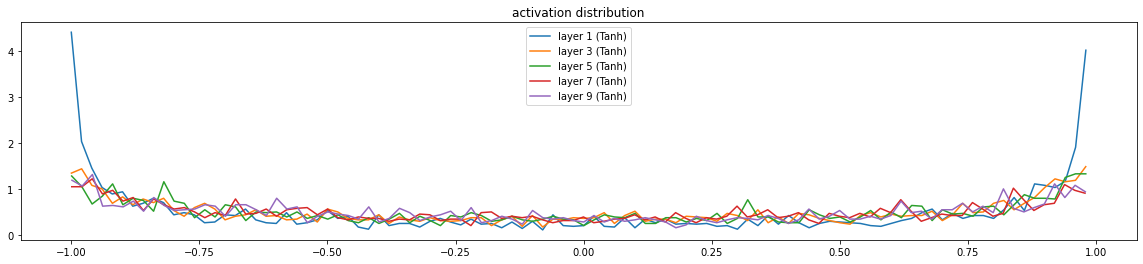

In [138]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh): #showing only for Tanh layer, because the graph extends between -1 to 1
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

In [139]:
#turns out 5/3 gain is providing good saturation point

layer 1 (      Tanh): mean -0.000018, std 4.739166e-04
layer 3 (      Tanh): mean -0.000013, std 4.471041e-04
layer 5 (      Tanh): mean +0.000020, std 4.165248e-04
layer 7 (      Tanh): mean +0.000008, std 3.662141e-04
layer 9 (      Tanh): mean +0.000010, std 3.220131e-04


Text(0.5, 1.0, 'gradient distribution')

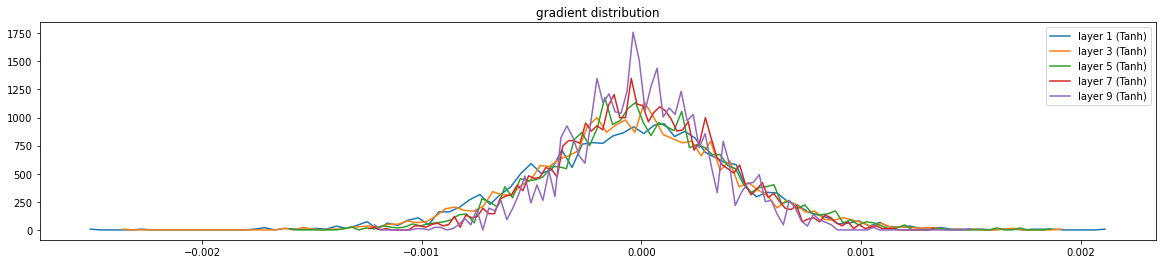

In [141]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad #taking grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

In [142]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
#put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 3.2570433616638184
val 3.256011962890625


In [143]:
#lets see how network reacts without non linear tanh function

In [157]:
layers = [
    Linear(n_embd * block_size, n_hidden), #Tanh(),
    Linear(           n_hidden, n_hidden), #Tanh(),
    Linear(           n_hidden, n_hidden), #Tanh(),
    Linear(           n_hidden, n_hidden), #Tanh(),
    Linear(           n_hidden, n_hidden), #Tanh(),
    Linear(           n_hidden, vocab_size),
]
#now it is easy to stack linear layers by calling class function

In [158]:
with torch.no_grad():
    #last layer: make output softmax function little less confident
    layers[-1].weight *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  1 # correct setting is 1 #5/3 #modify this gain and see how the visualization impacts

In [159]:
parameters = [C] + [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
print(sum(p.nelement() for p in parameters)) #no of parameter in total
for p in parameters:
    p.requires_grad = True

46497


In [160]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break #AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2900


layer 0 (    Linear): mean +0.04, std 0.98, saturated: 31.91%
layer 1 (    Linear): mean +0.02, std 0.99, saturated: 31.41%
layer 2 (    Linear): mean +0.06, std 0.97, saturated: 31.12%
layer 3 (    Linear): mean +0.00, std 0.97, saturated: 29.59%
layer 4 (    Linear): mean -0.05, std 0.94, saturated: 30.69%


Text(0.5, 1.0, 'activation distribution')

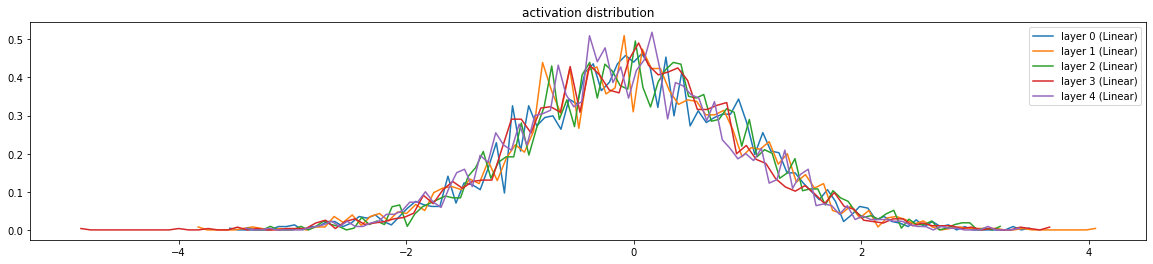

In [161]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Linear): #showing only for Tanh layer, because the graph extends between -1 to 1
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000002, std 2.789895e-04
layer 1 (    Linear): mean +0.000007, std 2.807050e-04
layer 2 (    Linear): mean +0.000003, std 2.859005e-04
layer 3 (    Linear): mean +0.000007, std 2.960411e-04
layer 4 (    Linear): mean -0.000006, std 3.020781e-04


Text(0.5, 1.0, 'gradient distribution')

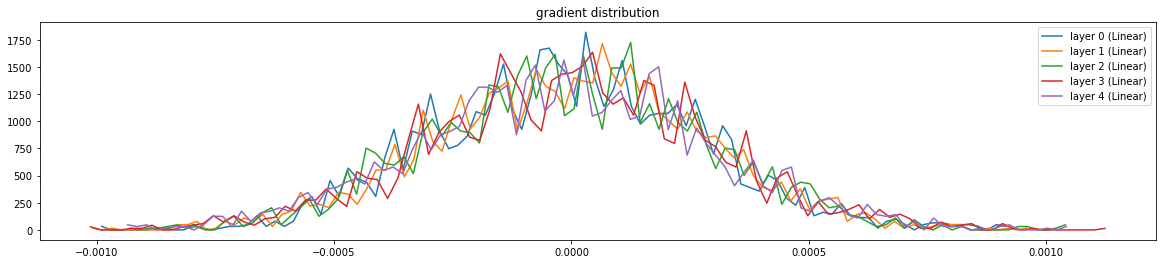

In [162]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad #taking grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

In [163]:
#Training neural network is like balancing perfectly, with activations, gradients etc...

weight   (27, 10) | mean -0.000194 | std 1.048962e-03 | grad:data 1.051080e-03
weight  (30, 100) | mean -0.000027 | std 1.452141e-03 | grad:data 7.915561e-03
weight (100, 100) | mean +0.000010 | std 1.481929e-03 | grad:data 1.477434e-02
weight (100, 100) | mean -0.000012 | std 1.587424e-03 | grad:data 1.581671e-02
weight (100, 100) | mean +0.000010 | std 1.576158e-03 | grad:data 1.576284e-02
weight (100, 100) | mean -0.000007 | std 1.616523e-03 | grad:data 1.615365e-02
weight  (100, 27) | mean +0.000000 | std 3.091170e-02 | grad:data 2.955391e+00


Text(0.5, 1.0, 'weights gradient distribution')

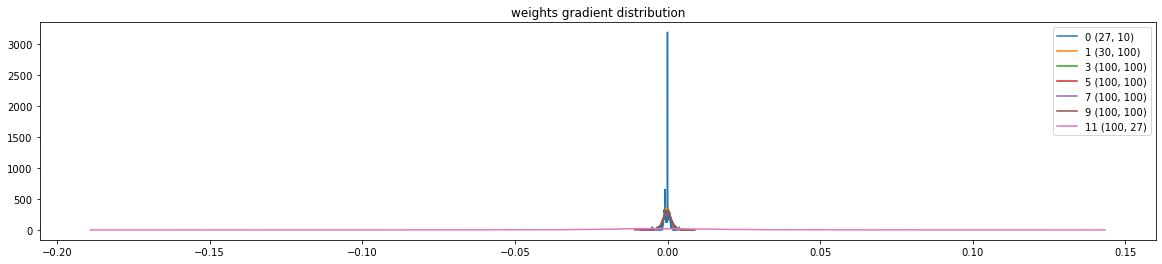

In [164]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, p in enumerate(parameters): #note: exclude the output layer
    t = p.grad #taking grad
    if p.ndim ==2: #restricting only 2 dim parameters, which are basically weights of linear layers
        print('weight %10s | mean %+f | std %e | grad:data %e' %(tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        #displaying gradient to data ration i.e. what is the scale of gradient compared to the scale of actual values
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [165]:
#gradient to data - sale of gradient compared to scale of actual values
#this is important that we take step update which is learning rate times the gradient on to the data, so
#the gradinet has too large of magnitude if the no's are too large compared to the no's in the data, then you're in trouble
#except last layers, this ratio is less. Eg for 1st layer, values of grad are 1000 times smaller than values inside data
#however for last layer is trouble maker - grad values are larger than data inside weights
#so, we will be training last layer 10 times faster than other layers at initialization

In [167]:
#We need update to the date raio, which is more informative than grad to data ratio
#because that is the amount by which we will actually change the data in these tensors

In [171]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
        #appending update to data list for vizualization
    if i >= 1000:
        break #AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.1234


Text(0.5, 1.0, 'updates distribution')

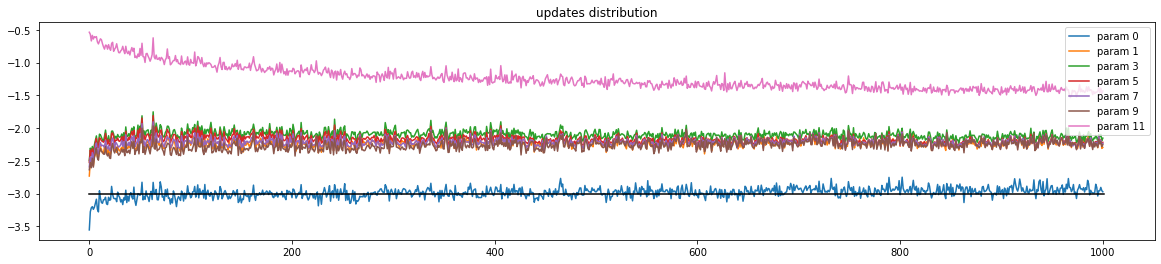

In [172]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, p in enumerate(parameters): #note: exclude the output layer
    if p.ndim ==2: #restricting only 2 dim parameters, which are basically weights of linear layers
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') #these ratios should be rought ~1e-3, indicate on plot
plt.legend(legends)
plt.title('updates distribution')

In [173]:
#Till now we have seen, linear networks with tanh and precisely calculated the gains and make the activations, the
#gradient and the parameters and the updates all look pretty decent
#all because gain is precisely calculated as 5/3 for tanh functions

#now, we will introduce batch norm layers into the fix and lets see how that helps fix the problem

In [174]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

In [175]:
C = torch.randn((vocab_size, n_embd), generator=g)

In [178]:
#placing batch norm betweem liner layer right after it and before non linearity
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), #instead of n_hidden, size is vocab_size
]
#can add batch norm after softmax also...

In [179]:
#because the last layer is batchnorm, we will not be change the weight to make the softmax less confident
#but we will be changing the gamma
#because gamma in batchnorm is the variable that multiply interacts with the output of normalization
with torch.no_grad():
    #last layer: make output softmax function little less confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #modify this gain and see how the visualization impacts

In [180]:
parameters = [C] + [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
print(sum(p.nelement() for p in parameters)) #no of parameter in total
for p in parameters:
    p.requires_grad = True

47551


In [181]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
        #appending update to data list for vizualization
    if i >= 1000:
        break #AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2951


In [182]:
#look at all the visualiztaions again...

layer 0 (    Linear): mean +0.10, std 1.65, saturated: 55.97%
layer 3 (    Linear): mean -0.00, std 1.12, saturated: 38.50%
layer 6 (    Linear): mean +0.00, std 1.10, saturated: 40.50%
layer 9 (    Linear): mean -0.01, std 1.15, saturated: 42.28%
layer 12 (    Linear): mean +0.00, std 1.20, saturated: 43.91%
layer 15 (    Linear): mean -0.00, std 1.43, saturated: 46.53%


Text(0.5, 1.0, 'activation distribution')

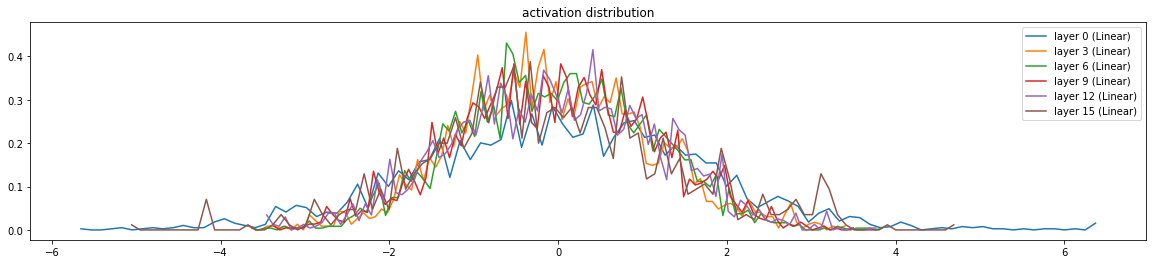

In [183]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Linear): #showing only for Tanh layer, because the graph extends between -1 to 1
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 0 (    Linear): mean -0.000000, std 1.614103e-03
layer 3 (    Linear): mean +0.000000, std 1.892700e-03
layer 6 (    Linear): mean -0.000000, std 1.719320e-03
layer 9 (    Linear): mean -0.000000, std 1.551417e-03
layer 12 (    Linear): mean -0.000000, std 1.508791e-03
layer 15 (    Linear): mean -0.000000, std 2.799308e-03


Text(0.5, 1.0, 'gradient distribution')

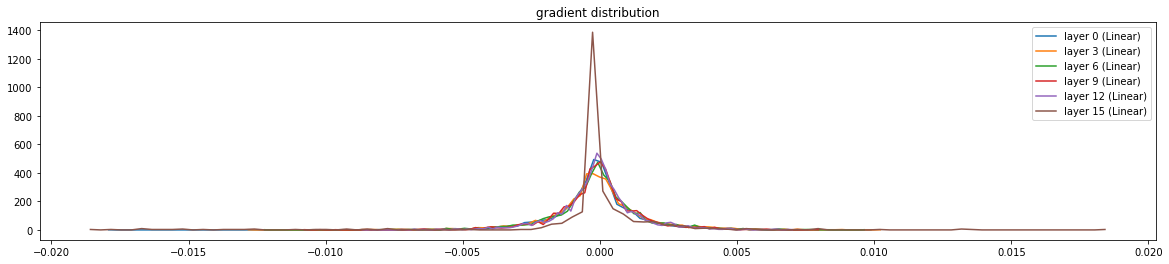

In [184]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad #taking grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.000378e-02 | grad:data 9.993267e-03
weight  (30, 100) | mean -0.000186 | std 8.417333e-03 | grad:data 2.747657e-02
weight (100, 100) | mean +0.000059 | std 6.887426e-03 | grad:data 4.097546e-02
weight (100, 100) | mean +0.000024 | std 6.291274e-03 | grad:data 3.736397e-02
weight (100, 100) | mean -0.000001 | std 5.617464e-03 | grad:data 3.361084e-02
weight (100, 100) | mean -0.000016 | std 5.430557e-03 | grad:data 3.249096e-02
weight  (100, 27) | mean -0.000073 | std 9.916822e-03 | grad:data 5.892190e-02


Text(0.5, 1.0, 'weights gradient distribution')

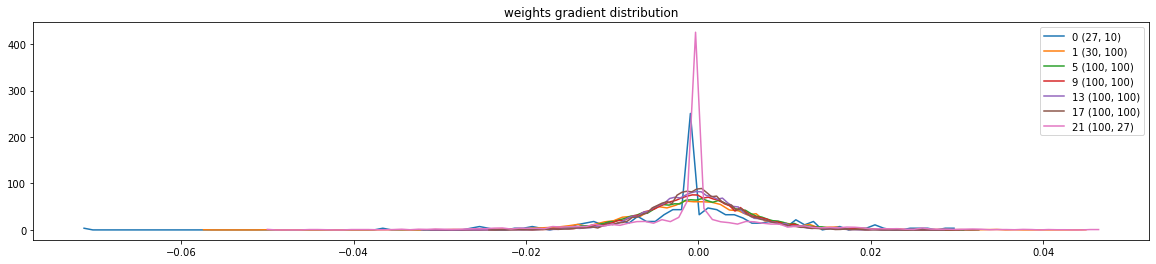

In [185]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, p in enumerate(parameters): #note: exclude the output layer
    t = p.grad #taking grad
    if p.ndim ==2: #restricting only 2 dim parameters, which are basically weights of linear layers
        print('weight %10s | mean %+f | std %e | grad:data %e' %(tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        #displaying gradient to data ration i.e. what is the scale of gradient compared to the scale of actual values
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

Text(0.5, 1.0, 'updates distribution')

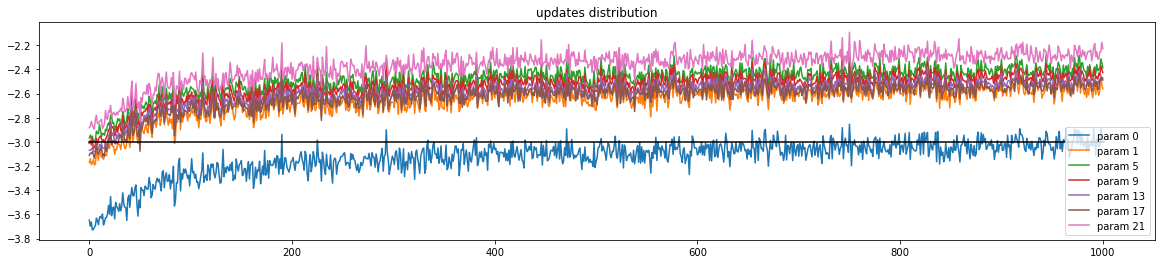

In [186]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and hight of the plot
legends = []
for i, p in enumerate(parameters): #note: exclude the output layer
    if p.ndim ==2: #restricting only 2 dim parameters, which are basically weights of linear layers
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') #these ratios should be rought ~1e-3, indicate on plot
plt.legend(legends)
plt.title('updates distribution')

In [187]:
#updates look better than previous

In [ ]:
#modify the gain and see how the visualization changes